In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import time

# Config Class
class Config:
    def __init__(self, dataset_name):
        self.problem = dataset_name
        self.num_diffusion_timesteps = 6
        self.n_batch_train = 8  
        self.lr = 1e-4
        self.beta_1 = 0.9
        self.dropout = 0.0
        self.num_epochs = 10
        self.grad_clip = True 
        self.mixed_precision = True  


class DatasetLoader:
    def __init__(self, name, batch_size):
        self.name = name
        self.batch_size = batch_size
        self.img_size = {"cifar10": 32, "celeba": 64}[name]

        if name == "cifar10":
            self.dataset = datasets.CIFAR10(
                root="./data", train=True, transform=self.get_transforms(), download=True
            )
        elif name == "celeba":
            self.dataset = datasets.CelebA(
                root="./data", split="train", transform=self.get_transforms(), download=True
            )
        else:
            raise ValueError(f"Dataset {name} not implemented.")

    def get_transforms(self):
        return transforms.Compose(
            [
                transforms.Resize(32),  
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )

    def get_loader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)


def get_timestep_embedding(timesteps, embedding_dim, device):
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1))
    return emb


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.temb_proj = nn.Linear(temb_dim, out_channels)
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, temb):
        h = self.activation(self.norm1(x))
        h = self.conv1(h)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.activation(self.norm2(h))
        h = self.conv2(h)
        return x + h


class DiffusionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.temb_dim = 128
        self.conv_in = nn.Conv2d(3, 128, 3, padding=1)
        self.res_blocks = nn.ModuleList(
            [ResNetBlock(128, 128, self.temb_dim) for _ in range(3)]
        )
        self.conv_out = nn.Conv2d(128, 3, 3, padding=1)
        self.temb_dense1 = nn.Linear(self.temb_dim, self.temb_dim)
        self.temb_dense2 = nn.Linear(self.temb_dim, self.temb_dim)

    def forward(self, x, t):
        temb = get_timestep_embedding(t, self.temb_dim, x.device)
        temb = nn.functional.relu(self.temb_dense1(temb))
        temb = self.temb_dense2(temb)

        h = self.conv_in(x)
        for block in self.res_blocks:
            h = block(h, temb)
        return self.conv_out(h)


def train(config, model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler() if config.mixed_precision else None

    for epoch in range(config.num_epochs):
        epoch_loss = 0
        optimizer.zero_grad()
        with tqdm(total=len(loader), desc=f"Epoch {epoch+1}/{config.num_epochs}", unit="batch") as pbar:
            for data, _ in loader:
                data = data.to(device)
                timesteps = torch.randint(0, config.num_diffusion_timesteps, (data.size(0),), device=device).float()
                noise = torch.randn_like(data)
                noisy_data = data + noise * (timesteps / config.num_diffusion_timesteps)[:, None, None, None]

                if config.mixed_precision:
                    with torch.cuda.amp.autocast():
                        pred_noise = model(noisy_data, timesteps)
                        loss = criterion(pred_noise, noise)
                    scaler.scale(loss).backward()
                    if config.grad_clip:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    pred_noise = model(noisy_data, timesteps)
                    loss = criterion(pred_noise, noise)
                    loss.backward()
                    if config.grad_clip:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                epoch_loss += loss.item()
                optimizer.zero_grad()
                pbar.set_postfix(loss=f"{loss.item():.4f}")
                pbar.update(1)

        print(f"Epoch {epoch+1} completed. Avg Loss: {epoch_loss/len(loader):.4f}")
        torch.cuda.empty_cache()  # Free memory after each epoch



In [10]:
DATASET = "celeba"
config = Config(DATASET)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# DataLoader
dataset_loader = DatasetLoader(DATASET, config.n_batch_train)
train_loader = dataset_loader.get_loader()


cuda


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=4c75126a-6f82-460f-8c10-114a3ab760c5
To: /home/onyxia/work/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:34<00:00, 41.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /home/onyxia/work/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 29.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /home/onyxia/work/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 34.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /home/onyxia/work/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 33.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ

In [11]:
model = DiffusionModel(config).to(device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)

train(config, model, train_loader, optimizer, device)

/tmp/ipykernel_874/3323554613.py:113: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if config.mixed_precision else None
/tmp/ipykernel_874/3323554613.py:126: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 20347/20347 [07:36<00:00, 44.58batch/s, loss=0.0542]


Epoch 1 completed. Avg Loss: 0.2346


Epoch 2/10: 100%|██████████| 20347/20347 [07:09<00:00, 47.34batch/s, loss=0.1067]


Epoch 2 completed. Avg Loss: 0.2267


Epoch 3/10: 100%|██████████| 20347/20347 [07:32<00:00, 45.00batch/s, loss=0.0809]


Epoch 3 completed. Avg Loss: 0.2252


Epoch 4/10: 100%|██████████| 20347/20347 [07:11<00:00, 47.11batch/s, loss=0.5208]


Epoch 4 completed. Avg Loss: 0.2257


Epoch 5/10: 100%|██████████| 20347/20347 [07:24<00:00, 45.74batch/s, loss=0.1086]


Epoch 5 completed. Avg Loss: 0.2226


Epoch 6/10: 100%|██████████| 20347/20347 [07:25<00:00, 45.66batch/s, loss=0.0611]


Epoch 6 completed. Avg Loss: 0.2212


Epoch 7/10: 100%|██████████| 20347/20347 [07:25<00:00, 45.63batch/s, loss=0.0590]


Epoch 7 completed. Avg Loss: 0.2239


Epoch 8/10: 100%|██████████| 20347/20347 [07:27<00:00, 45.52batch/s, loss=0.5279]


Epoch 8 completed. Avg Loss: 0.2220


Epoch 9/10: 100%|██████████| 20347/20347 [07:32<00:00, 44.92batch/s, loss=0.0898]


Epoch 9 completed. Avg Loss: 0.2222


Epoch 10/10: 100%|██████████| 20347/20347 [07:14<00:00, 46.82batch/s, loss=0.5242]

Epoch 10 completed. Avg Loss: 0.2229


In [12]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import numpy as np


def calculate_fid(real_features, generated_features):
    """Calculate FID score."""
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Extract features using InceptionV3
def extract_features(dataloader, model, device):
    model.eval()
    features = []
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            pred = model(data)
            features.append(pred.cpu().numpy())
    return np.concatenate(features, axis=0)

In [13]:
def generate_samples(model, config, num_samples=64, device="cuda"):
    model.eval()
    with torch.no_grad():
        # random noise
        samples = torch.randn(num_samples, 3, 32, 32, device=device)

        for t in reversed(range(config.num_diffusion_timesteps)):
            timesteps = torch.full((num_samples,), t, device=device).float()
            pred_noise = model(samples, timesteps)
            samples = samples - pred_noise * (1.0 / config.num_diffusion_timesteps)

        samples = (samples.clamp(-1, 1) + 1) / 2
        return samples

def plot_samples(samples, nrows=8, ncols=8):
    samples = samples.permute(0, 2, 3, 1).cpu().numpy()  
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i < len(samples):
            ax.imshow(samples[i])
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [15]:
# Pretrained InceptionV3 for feature extraction
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = nn.Identity()  # Remove final classification layer
inception_model.to(device)


real_features = extract_features(train_loader, inception_model, device)
generated_samples = generate_samples(model, config, num_samples=256, device=device)
generated_dataset = torch.utils.data.DataLoader(
    generated_samples, batch_size=config.n_batch_train
)
generated_features = extract_features(generated_dataset, inception_model, device)


fid_score = calculate_fid(real_features, generated_features)
print(f"FID Score: {fid_score}")

RuntimeError: Calculated padded input size per channel: (2 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

The issue mentioned above could be resolved by training on higher resolution images. 
However, due to limited computational resources, we were unable to train on larger image sizes.

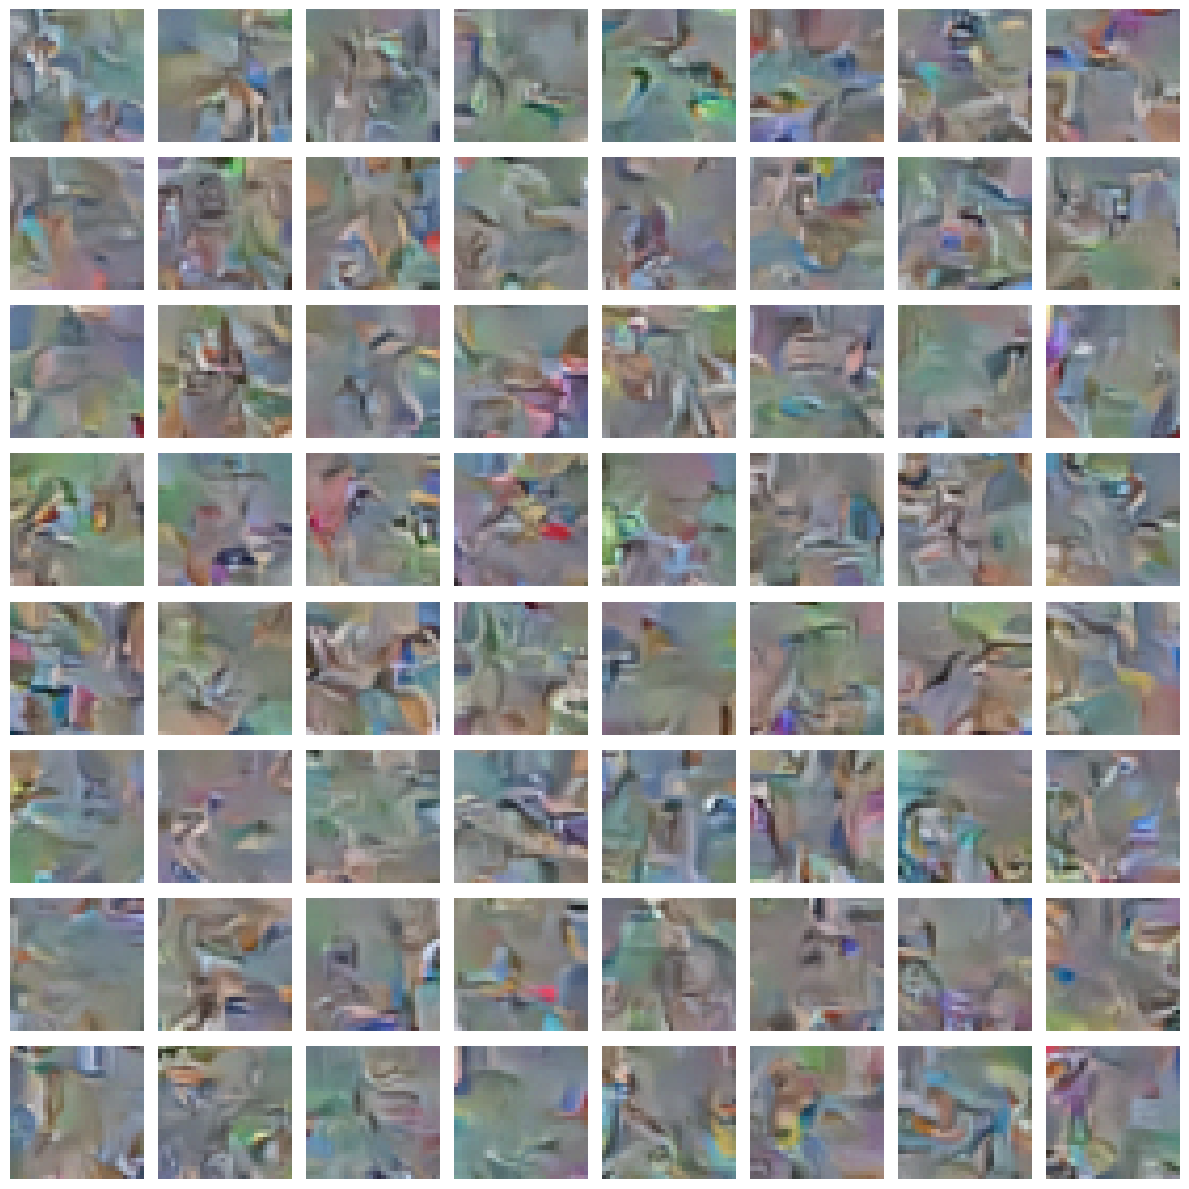

In [16]:
samples = generate_samples(model, config, num_samples=64, device=device)

plot_samples(samples)

The quality of the generated samples is poor because we were unable to train with a sufficiently large batch size and for enough epochs due to limited computational resources.